In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
connection = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
q = """
SELECT 
  cast(assumeNotNull(date_order) as text) as date_order, 
  number_order,
  cast(assumeNotNull(planned_data_order) as text) as planned_data_order,
  timeslot_number, 
  cast(assumeNotNull(result_data_order) as text) as result_data_order,
  delivery_type,
  carrier_name,
  seller_ID,
  order_status,
  customer_cluster,
  warehouse_cluster
FROM default.logistics_online
"""

In [4]:
q1 = """
SELECT * 
FROM default.product_online
"""

In [5]:
q2 = """
SELECT * 
FROM default.returns_online
"""

In [6]:
logistics = ph.read_clickhouse(query = q, connection = connection)
logistics.head(3)

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster
0,2021-5-01,313655114,2021-14-01,1,2021-11-01,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва
1,2021-3-01,315229153,2021-11-01,1,2021-8-01,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область
2,2021-8-01,3114106095,2021-16-01,1,2021-14-01,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область


In [7]:
products = ph.read_clickhouse(query = q1, connection = connection)
products.head()

,number_order,product_ID,product_price,amount
0,313655114,983587801,5512.44,1
1,313655114,983587158,4070.35,2
2,313655114,983582669,3591.97,1
3,315229153,983589424,4433.23,3
4,315229153,983587827,2862.50,2


In [8]:
returns = ph.read_clickhouse(query = q2, connection = connection)
returns.head()

,number_order,product_ID,amount_return,return_date
0,3031410942,983588011,1,1970-01-01
1,31014374140,983586554,1,2021-07-01
2,3147145173,983589156,1,2021-11-01
3,3141464669,983589362,1,2021-11-01
4,3131450699,983589729,3,2021-12-01


## Предобработка данных

In [9]:
logistics.dtypes

date_order            object
number_order           int64
planned_data_order    object
timeslot_number         int8
result_data_order     object
delivery_type         object
carrier_name          object
seller_ID              int64
order_status          object
customer_cluster      object
warehouse_cluster     object
dtype: object

**Нужно сконвертировать тип данных в столбцах с  датами и сменить формат с YYYY-DD-MM на YYYY-MM-DD**

In [10]:
# меняем местами день и месяц
def date_exchange(x):
    if x != '':
        x = x.split('-')
        x[1], x[2] = x[2], x[1]
        if len(x[1]) > 2:
            x[1] = x[1][-2:]
        else:
            pass
        return pd.to_datetime('-'.join(x))
    else:
        return np.nan
    
logistics['date_order'] = logistics['date_order'].apply(date_exchange)
logistics['planned_data_order'] = logistics['planned_data_order'].apply(date_exchange)
logistics['result_data_order'] = logistics['result_data_order'].apply(date_exchange)

In [11]:
logistics.head(3)

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster
0,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва
1,2021-01-03,315229153,2021-01-11,1,2021-01-08,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область
2,2021-01-08,3114106095,2021-01-16,1,2021-01-14,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область


**Проверяем наличие дубликатов и удаляем их**

In [12]:
logistics.duplicated().sum()

1

In [13]:
logistics = logistics.drop_duplicates().reset_index(drop=True)

**Проверяем корректность внесения дат заказа и доставки**

In [14]:
sum(logistics['date_order'] > logistics['planned_data_order'])

0

In [15]:
sum(logistics['date_order'] > logistics['result_data_order'])

947

In [16]:
logistics.number_order.nunique()

5976

947 строк из 5976 (16%) содержат ошибку: записи утверждают, что заказ был сделан позже, чем доставлен. Это явно ошибочные данные, их лучше удалить

In [17]:
logistics['date_err'] = logistics['date_order'] > logistics['result_data_order']
logistics.drop(logistics[logistics['date_err']==True].index, inplace=True)
# еще раз проверим даты на наличие ошибок
sum(logistics['date_order'] > logistics['result_data_order'])

0

In [18]:
products.dtypes

number_order       int64
product_ID         int64
product_price    float64
amount             int16
dtype: object

In [19]:
returns.dtypes

number_order              int64
product_ID                int64
amount_return              int8
return_date      datetime64[ns]
dtype: object

In [20]:
returns.head()

,number_order,product_ID,amount_return,return_date
0,3031410942,983588011,1,1970-01-01
1,31014374140,983586554,1,2021-07-01
2,3147145173,983589156,1,2021-11-01
3,3141464669,983589362,1,2021-11-01
4,3131450699,983589729,3,2021-12-01


In [21]:
returns.return_date.value_counts().head()

1970-01-01    253
2021-05-03     31
2021-04-03     20
2021-07-03     18
2021-11-03     17
Name: return_date, dtype: int64

In [22]:
returns.shape

(496, 4)

Половина записей имеют неверную дату, что может быть следствием некорректной конвертации типа данных в SQL, если даты по ошибке заводились в формате YYYY-DD-MM. Восстановить точные даты мы не в силах, можем только сконвертировать их в формат YYYY-MM-DD и помнить, что результаты расчета некоторых метрик будут искажены

In [23]:
returns['return_date'] = pd.to_datetime(returns['return_date'].astype(str), format ='%Y-%d-%m')

## Расчет метрик

### OnTime - Своевременность доставки в % (доставили в плановую дату или нет)

 - Визуализировать изменение метрики по дням;
 - Визуализировать разрезы 
     - по перевозчикам
     - типу доставки
     - кластерам склада
     - таймслотам

In [41]:
# Создаем массив, содержащий данные только по доставленным заказам
logistics_done = logistics.drop(logistics[logistics.result_data_order.isna()].index)

In [42]:
# Добавляем столбец, содержащий статус своевременности доставки
def ontime(row):
    if row['planned_data_order'] == row['result_data_order']:
        return 1
    else:
        return 0
logistics_done['ontime'] = logistics_done.apply(ontime, axis=1)

**Строим график изменения метрики**

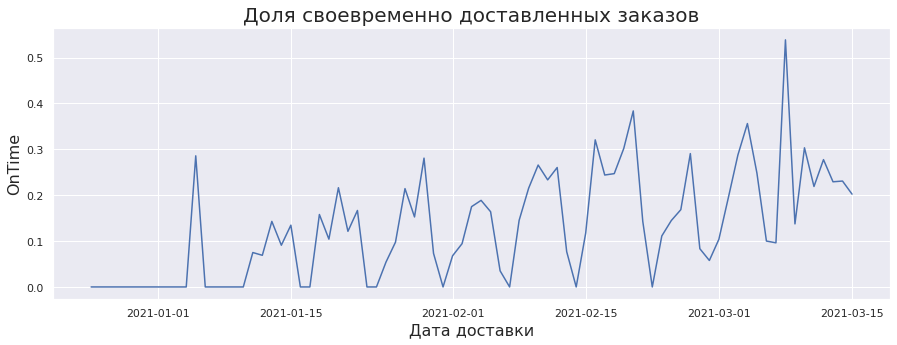

In [44]:
# Группируем по дате и считаем долю доставленных вовремя заказов
ontime_daily = logistics_done.groupby('result_data_order', as_index=False).ontime.mean()

sns.set(rc={'figure.figsize':(15,5)})
p = sns.lineplot(data = ontime_daily, x='result_data_order', y = 'ontime')
p.set_title("Доля своевременно доставленных заказов",fontsize=20)
p.set_xlabel("Дата доставки",fontsize=16)
p.set_ylabel("OnTime",fontsize=16)
plt.show()

**OnTime перевозчиков**

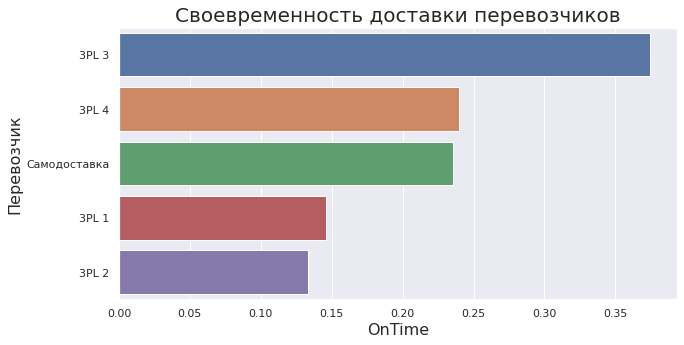

In [45]:
carrier_ontime  = logistics_done.groupby('carrier_name', as_index=False).ontime.mean()\
                    .sort_values('ontime', ascending=False)
sns.set(rc={'figure.figsize':(10,5)})
p = sns.barplot(data = carrier_ontime, y='carrier_name', x = 'ontime')
p.set_title("Своевременность доставки перевозчиков",fontsize=20)
p.set_xlabel("OnTime",fontsize=16)
p.set_ylabel("Перевозчик",fontsize=16)
plt.show()

**OnTime способов доставки**

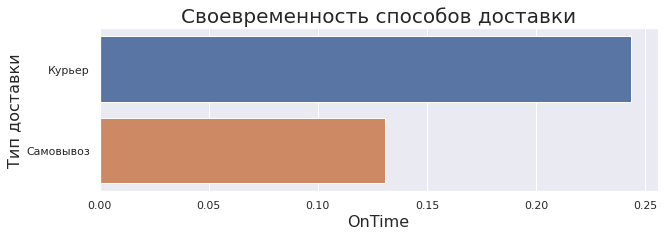

In [46]:
delivery_type_ontime  = logistics_done.groupby('delivery_type', as_index=False).ontime.mean()\
                        .sort_values('ontime', ascending=False)
sns.set(rc={'figure.figsize':(10,3)})
p = sns.barplot(data = delivery_type_ontime, y='delivery_type', x = 'ontime')
p.set_title("Своевременность способов доставки",fontsize=20)
p.set_xlabel("OnTime",fontsize=16)
p.set_ylabel("Тип доставки",fontsize=16)
plt.show()

**OnTime по регионам**

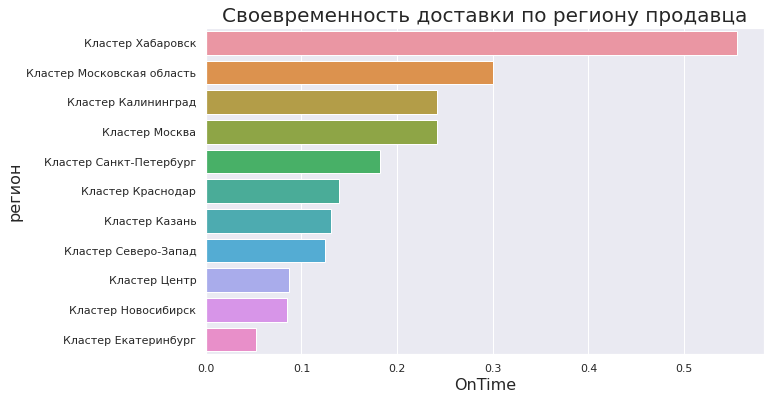

In [47]:
cluster_ontime  = logistics_done.groupby('warehouse_cluster', as_index=False).ontime.mean()\
                    .sort_values('ontime', ascending=False)
sns.set(rc={'figure.figsize':(10,6)})
p = sns.barplot(data = cluster_ontime, y='warehouse_cluster', x = 'ontime')
p.set_title("Своевременность доставки по региону продавца",fontsize=20)
p.set_xlabel("OnTime",fontsize=16)
p.set_ylabel("регион",fontsize=16)
plt.show()

**OnTime для разных попыток доставки**

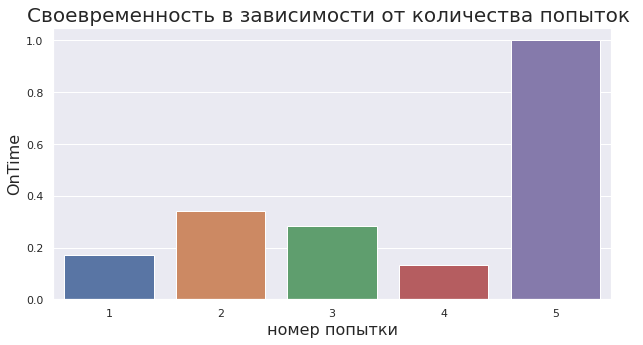

In [49]:
timeslot_ontime = logistics_done.groupby('timeslot_number', as_index=False).ontime.mean()\
                    .sort_values('ontime', ascending=False)
sns.set(rc={'figure.figsize':(10,5)})
p = sns.barplot(data = timeslot_ontime, x='timeslot_number', y = 'ontime')
p.set_title("Своевременность в зависимости от количества попыток ",fontsize=20)
p.set_xlabel("номер попытки",fontsize=16)
p.set_ylabel("OnTime",fontsize=16)
plt.show()

### PromisedClick2Delivery - обещанный срок доставки (от даты заказа до плановой даты доставки)

 - Визуализировать изменение метрики по дням, неделям, месяцам;
 - Визуализировать разрезы 
     - по перевозчикам
     - по регионам

### Click2Delivery - фактический срок доставки (от даты заказа до момента вручения)

 - Визуализировать сравнение с метрикой PromisedClick2Delivery;
 - Выделить регионы, в которых заказы доставляются быстрее, чем мы обещается

In [50]:
# Отбираем данные только по первой попытке доставки
logistics_slot = logistics_done.drop(logistics_done[logistics_done['timeslot_number'] != 1].index)

In [51]:
# Добавляем расчет метрик
logistics_slot['pc2d'] = (logistics_slot['planned_data_order'] - logistics_slot['date_order']).dt.days
logistics_slot['c2d'] = (logistics_slot['result_data_order'] - logistics_slot['date_order']).dt.days

In [52]:
logistics_slot.head(2)

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster,date_err,ontime,pc2d,c2d
0,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,0,9,6
1,2021-01-03,315229153,2021-01-11,1,2021-01-08,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область,False,0,8,5


**Дневная динамика**

In [53]:
c2d_daily = logistics_slot.groupby('date_order', as_index=False).agg({'pc2d':'mean', 'c2d':'mean'})
c2d_daily.head(3)

,date_order,pc2d,c2d
0,2020-12-21,11.0,4.0
1,2020-12-22,11.0,14.0
2,2020-12-23,9.0,6.0


In [54]:
#Переводим таблицу из "широкого" формата в "длинный"
c2d_daily = c2d_daily.melt('date_order', var_name='metrics', value_name='days')
c2d_daily.head(3)

,date_order,metrics,days
0,2020-12-21,pc2d,11.0
1,2020-12-22,pc2d,11.0
2,2020-12-23,pc2d,9.0


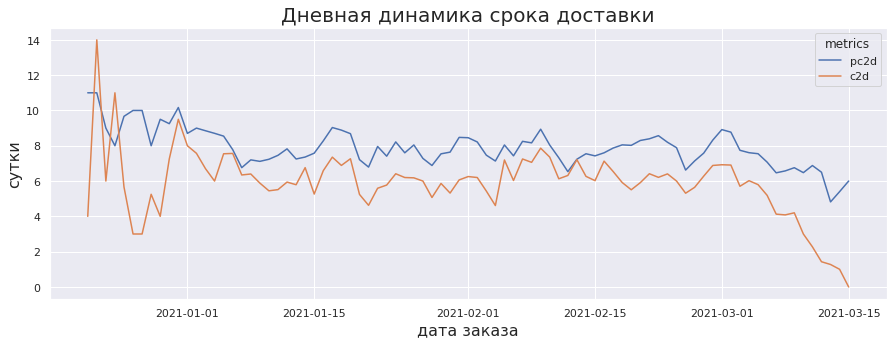

In [55]:
sns.set(rc={'figure.figsize':(15,5)})
p = sns.lineplot(data=c2d_daily, x='date_order', y = 'days', hue = 'metrics')
p.set_title("Дневная динамика срока доставки",fontsize=20)
p.set_xlabel("дата заказа",fontsize=16)
p.set_ylabel("сутки",fontsize=16)
plt.show()

**Недельная динамика**

In [56]:
c2d_weekly = logistics_slot
c2d_weekly.head(3)

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster,date_err,ontime,pc2d,c2d
0,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,0,9,6
1,2021-01-03,315229153,2021-01-11,1,2021-01-08,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область,False,0,8,5
2,2021-01-08,3114106095,2021-01-16,1,2021-01-14,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область,False,0,8,6


In [57]:
# Приводим дату заказа к дате первого дня недели, в которую был сделан заказ
c2d_weekly['date_order'] = c2d_weekly['date_order'].dt.to_period('W').dt.start_time
c2d_weekly.head(3)

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster,date_err,ontime,pc2d,c2d
0,2021-01-04,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,0,9,6
1,2020-12-28,315229153,2021-01-11,1,2021-01-08,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область,False,0,8,5
2,2021-01-04,3114106095,2021-01-16,1,2021-01-14,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область,False,0,8,6


In [58]:
c2d_weekly = c2d_weekly.groupby('date_order', as_index=False).agg({'pc2d':'mean', 'c2d':'mean'})
#Переводим таблицу из "широкого" формата в "длинный"
c2d_weekly = c2d_weekly.melt('date_order', var_name='metrics', value_name='days')

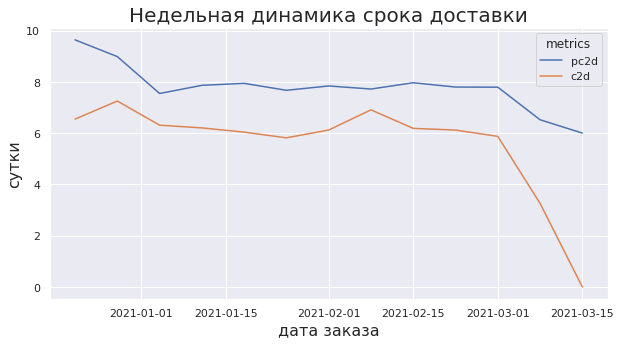

In [71]:
sns.set(rc={'figure.figsize':(10,5)})
p = sns.lineplot(data=c2d_weekly, x='date_order', y = 'days', hue = 'metrics')
p.set_title("Недельная динамика срока доставки",fontsize=20)
p.set_xlabel("дата заказа",fontsize=16)
p.set_ylabel("сутки",fontsize=16)
plt.show()

**Месячная динамика**

In [72]:
c2d_monthly = logistics_slot
# Приводим дату заказа к дате первого дня месяца, в котором началась неделя, в которую был сделан заказ
c2d_monthly['date_order'] = c2d_monthly['date_order'].dt.to_period('M').dt.start_time
c2d_monthly.head(3)

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster,date_err,ontime,pc2d,c2d,delivery_dif
0,2021-01-01,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,0,9,6,3
1,2020-12-01,315229153,2021-01-11,1,2021-01-08,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область,False,0,8,5,3
2,2021-01-01,3114106095,2021-01-16,1,2021-01-14,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область,False,0,8,6,2


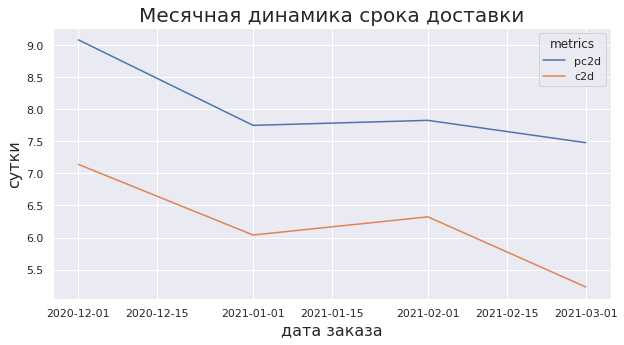

In [73]:
c2d_monthly = c2d_monthly.groupby('date_order', as_index=False).agg({'pc2d':'mean', 'c2d':'mean'})
#Переводим таблицу из "широкого" формата в "длинный"
c2d_monthly = c2d_monthly.melt('date_order', var_name='metrics', value_name='days')
p = sns.lineplot(data=c2d_monthly, x='date_order', y = 'days', hue = 'metrics')
p.set_title("Месячная динамика срока доставки",fontsize=20)
p.set_xlabel("дата заказа",fontsize=16)
p.set_ylabel("сутки",fontsize=16)
plt.show()

**Сроки доставки разных перевозчиков**

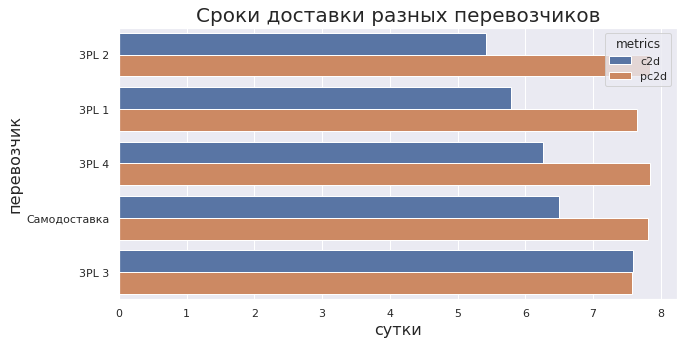

In [74]:
carrier_c2d = logistics_slot.groupby('carrier_name', as_index=False).agg({'pc2d':'mean', 'c2d':'mean'})
carrier_c2d = carrier_c2d.melt('carrier_name', var_name='metrics', value_name='days').sort_values('days', ascending=True)
p = sns.barplot(data=carrier_c2d, y='carrier_name', x = 'days', hue = 'metrics')
p.set_title("Сроки доставки разных перевозчиков",fontsize=20)
p.set_xlabel("сутки",fontsize=16)
p.set_ylabel("перевозчик",fontsize=16)
plt.show()

**Визуализируем значения PromisedClick2Delivery по регионам**

In [63]:
#считаем среднее значение метрики
cluster_pc2d = logistics_slot.groupby(['warehouse_cluster', 'customer_cluster'], as_index=False).pc2d.mean().sort_values('pc2d', ascending=True)
cluster_pc2d.head()

,warehouse_cluster,customer_cluster,pc2d
69,Кластер Новосибирск,Кластер Калининград,5.0
102,Кластер Хабаровск,Кластер Московская область,6.0
66,Кластер Московская область,Кластер Якутия,6.0
44,Кластер Краснодар,Кластер Якутия,6.0
101,Кластер Хабаровск,Кластер Москва,6.0


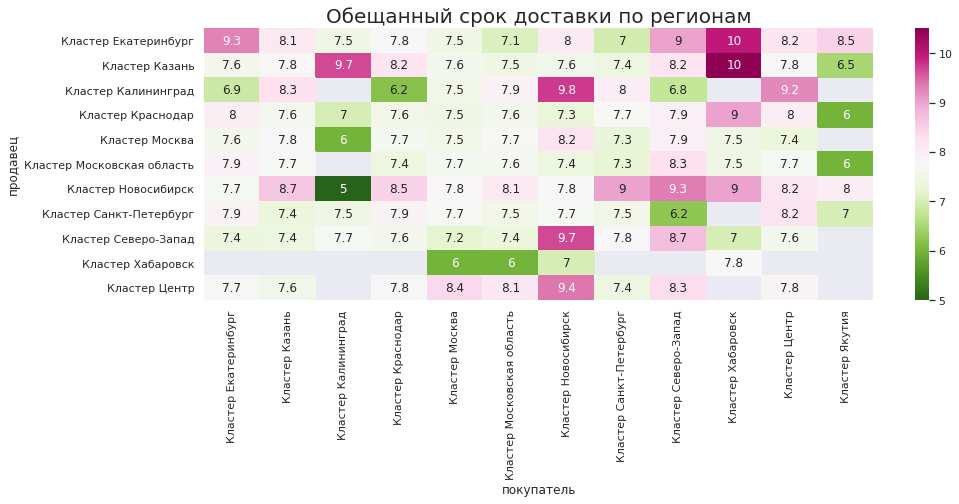

In [64]:
# визуализируем сводную таблицу
p = sns.heatmap(cluster_pc2d.pivot(index='warehouse_cluster', columns='customer_cluster', values='pc2d'), annot=True, cmap='PiYG_r')
p.set_title("Обещанный срок доставки по регионам",fontsize=20)
p.set_xlabel("покупатель",fontsize=12)
p.set_ylabel("продавец",fontsize=12)
plt.show()

**Выявляем кластеры, в которых заказы доставляются быстрее, чем запланировано**

In [75]:
delivery_dif = logistics_slot
delivery_dif['delivery_dif'] = delivery_dif['pc2d'] - delivery_dif['c2d']

#считаем среднее значение разница по регионам продавца
delivery_dif_car = delivery_dif.groupby('warehouse_cluster', as_index=False)\
                    .agg({'delivery_dif':'mean'}).sort_values('delivery_dif', ascending=False)

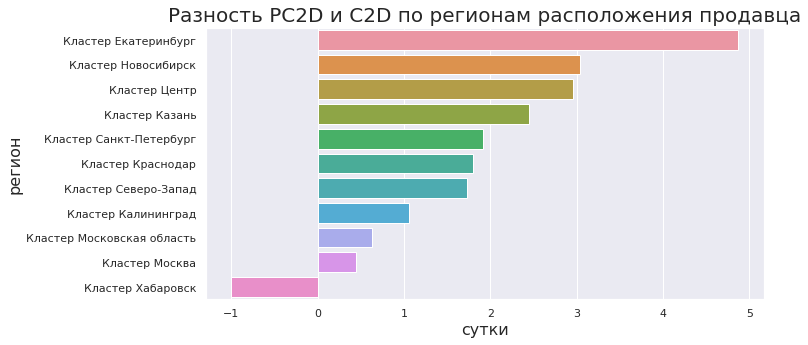

In [76]:
p = sns.barplot(data=delivery_dif_car, x='delivery_dif', y = 'warehouse_cluster')
p.set_title("Разность PC2D и C2D по регионам расположения продавца",fontsize=20)
p.set_xlabel("сутки",fontsize=16)
p.set_ylabel("регион",fontsize=16)
plt.show()

In [77]:
#считаем среднее значение разница по регионам покупателя
delivery_dif_cust = delivery_dif.groupby('customer_cluster', as_index=False)\
                    .agg({'delivery_dif':'mean'}).sort_values('delivery_dif', ascending=False)

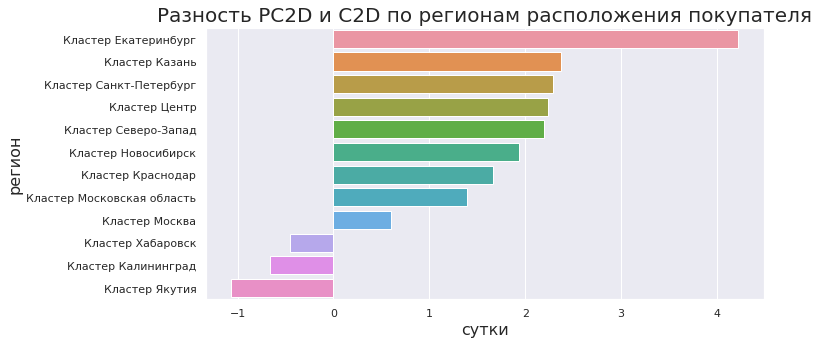

In [79]:
sns.set(rc={'figure.figsize':(10,5)})
p = sns.barplot(data=delivery_dif_cust, x='delivery_dif', y = 'customer_cluster')
p.set_title("Разность PC2D и C2D по регионам расположения покупателя",fontsize=20)
p.set_xlabel("сутки",fontsize=16)
p.set_ylabel("регион",fontsize=16)
plt.show()

### GMV Accepted - совокупный объем продаж, руб. (по заказам, оформленным в указанный день)

 - Визуализировать изменение метрики по дням;
 - Визуализировать разрезы по:
     - перевозчикам
     - типу доставки
     - региону нахождения продавца

Нам понадобится объединенный датафрейм, содержащий данные по товарам и логистике

In [80]:
gross = logistics.merge(products, on='number_order', how='left')
# рассчитываем итоговую цену заказа
gross['gmv_accept'] = gross['product_price'] * gross['amount']
gross.head(3)

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster,date_err,product_ID,product_price,amount,gmv_accept
0,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,983587801,5512.44,1,5512.44
1,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,983587158,4070.35,2,8140.70
2,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,983582669,3591.97,1,3591.97


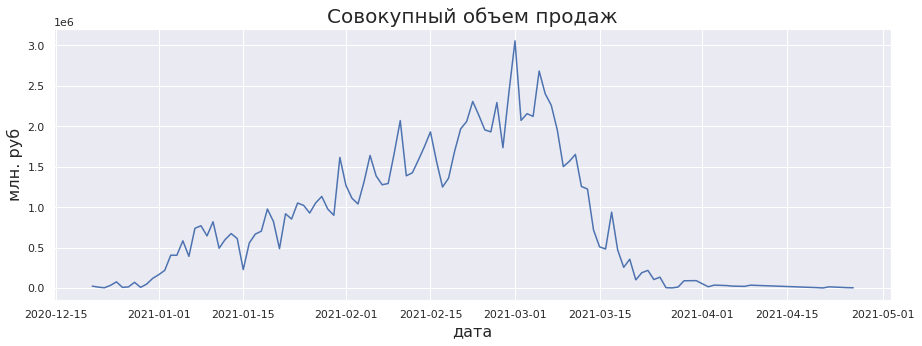

In [83]:
sns.set(rc={'figure.figsize':(15,5)})
p = sns.lineplot(data = gross.groupby('date_order', as_index=False).gmv_accept.sum(), x='date_order', y='gmv_accept')
p.set_title("Cовокупный объем продаж",fontsize=20)
p.set_xlabel("дата",fontsize=16)
p.set_ylabel("млн. руб",fontsize=16)
plt.show()

**Объем продаж по перевозчикам**

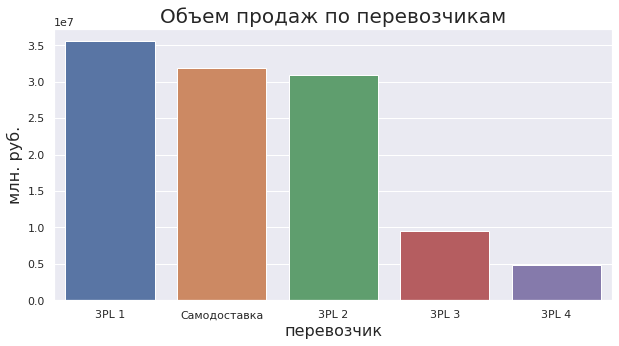

In [84]:
sns.set(rc={'figure.figsize':(10,5)})
p = sns.barplot(data = gross.groupby('carrier_name', as_index=False).gmv_accept.sum() \
                .sort_values('gmv_accept', ascending=False), x='carrier_name', y='gmv_accept')
p.set_title("Объем продаж по перевозчикам",fontsize=20)
p.set_xlabel("перевозчик",fontsize=16)
p.set_ylabel("млн. руб.",fontsize=16)
plt.show()

**Объем продаж по типу доставки**

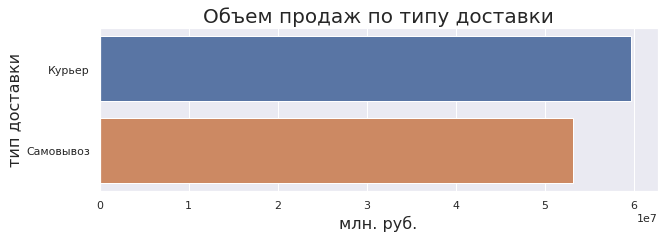

In [85]:
sns.set(rc={'figure.figsize':(10,3)})
p = sns.barplot(data = gross.groupby('delivery_type', as_index=False).gmv_accept.sum() \
                .sort_values('gmv_accept', ascending=False), x='gmv_accept', y='delivery_type')
p.set_title("Объем продаж по типу доставки",fontsize=20)
p.set_xlabel("млн. руб.",fontsize=16)
p.set_ylabel("тип доставки",fontsize=16)
plt.show()

**Объем продаж по региону продавца**

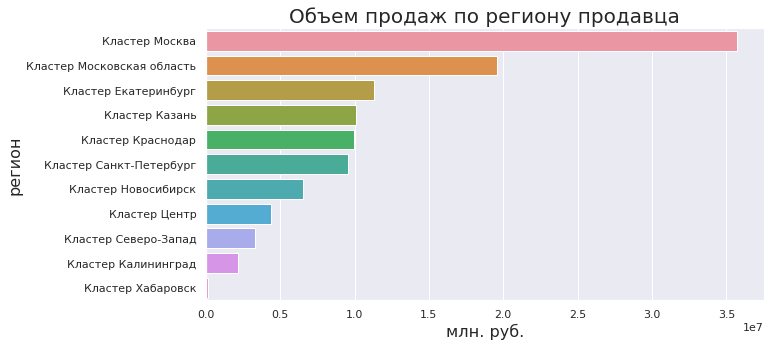

In [86]:
sns.set(rc={'figure.figsize':(10,5)})
p = sns.barplot(data = gross.groupby('warehouse_cluster', as_index=False).gmv_accept.sum() \
                .sort_values('gmv_accept', ascending=False), x='gmv_accept', y='warehouse_cluster')
p.set_title("Объем продаж по региону продавца",fontsize=20)
p.set_xlabel("млн. руб.",fontsize=16)
p.set_ylabel("регион",fontsize=16)
plt.show()

### Return Rate - доля возвратов в % (отношение количества возвратов к заказам в этот день)

 - Визуализировать изменение метрики по дням;
 - Визуализировать разрезы по:
     - перевозчикам
     - региону нахождения продавца
     - региону нахождения клиента

In [87]:
# Количество заказов по дням
orders_daily = gross.groupby('date_order', as_index=False).amount.sum()
orders_daily.head()

,date_order,amount
0,2020-12-21,6
1,2020-12-22,2
2,2020-12-23,1
3,2020-12-24,6
4,2020-12-25,13


In [88]:
returns_daily = returns.groupby('return_date', as_index=False).amount_return.sum()
returns_daily.head()

,return_date,amount_return
0,1970-01-01,388.0
1,2021-01-07,1.0
2,2021-01-11,2.0
3,2021-01-12,7.0
4,2021-02-01,7.0


In [89]:
returns_daily.shape

(28, 2)

In [90]:
## Удалим записи с неверной датой
returns_daily = returns_daily[returns_daily['return_date'] > pd.to_datetime('01-01-2020')]

In [91]:
returns_daily.head()

,return_date,amount_return
1,2021-01-07,1.0
2,2021-01-11,2.0
3,2021-01-12,7.0
4,2021-02-01,7.0
5,2021-02-02,6.0


In [92]:
returns_daily.shape

(27, 2)

In [93]:
# Объединяем данные о покупках и возвратах
return_rate = orders_daily.merge(returns_daily, left_on='date_order', right_on='return_date', how='outer')
return_rate.head()

,date_order,amount,return_date,amount_return
0,2020-12-21,6,NaT,NaN
1,2020-12-22,2,NaT,NaN
2,2020-12-23,1,NaT,NaN
3,2020-12-24,6,NaT,NaN
4,2020-12-25,13,NaT,NaN


In [94]:
# Заменим недостающие данные нулями и посчитаем метрику
return_rate['amount_return'] = return_rate.amount_return.fillna(0)
return_rate['return_rate'] = (return_rate['amount_return'] / return_rate['amount']) * 100

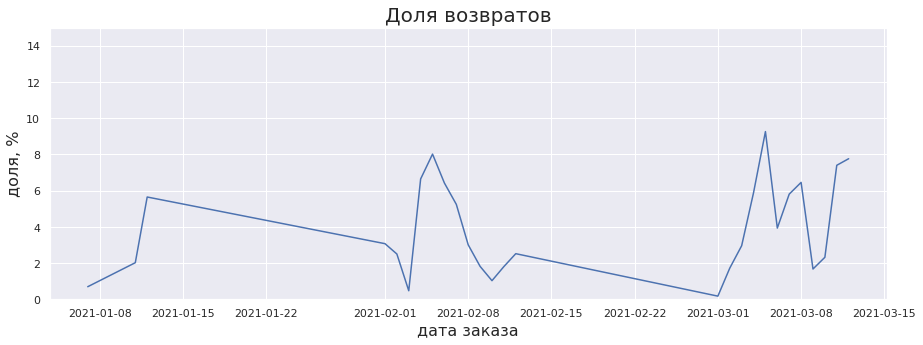

In [95]:
sns.set(rc={'figure.figsize':(15,5)})
p = sns.lineplot(data = return_rate, x='return_date', y='return_rate')
p.set_title("Доля возвратов",fontsize=20)
p.set_xlabel("дата заказа",fontsize=16)
p.set_ylabel("доля, %",fontsize=16)
p.set(ylim=(0, 15))
plt.show()

**Return rate по перевозчикам**

In [96]:
overall = gross.merge(returns, on = ['number_order','product_ID'], how='left')
overall.head(3)

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster,date_err,product_ID,product_price,amount,gmv_accept,amount_return,return_date
0,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,983587801,5512.44,1,5512.44,NaN,NaT
1,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,983587158,4070.35,2,8140.70,NaN,NaT
2,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,983582669,3591.97,1,3591.97,NaN,NaT


In [97]:
# Заменим недостающие данные нулями и посчитаем метрику
overall['amount_return'] = overall.amount_return.fillna(0)
overall['return_rate'] = (overall['amount_return'] / overall['amount'])*100

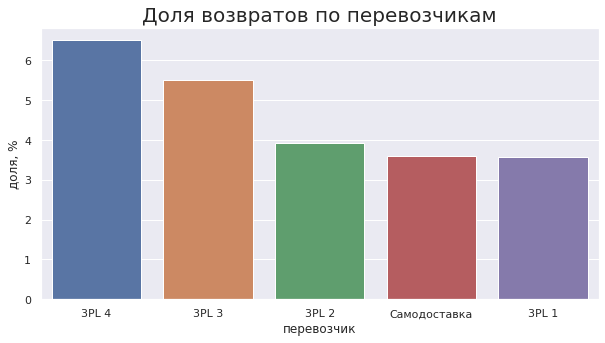

In [98]:
sns.set(rc={'figure.figsize':(10,5)})
p = sns.barplot(data = overall.groupby('carrier_name', as_index=False).return_rate.mean() \
        .sort_values('return_rate', ascending=False), x='carrier_name', y='return_rate')
p.set_title("Доля возвратов по перевозчикам",fontsize=20)
p.set_xlabel("перевозчик",fontsize=12)
p.set_ylabel("доля, %",fontsize=12)
plt.show()

**Return rate по региону продавца**

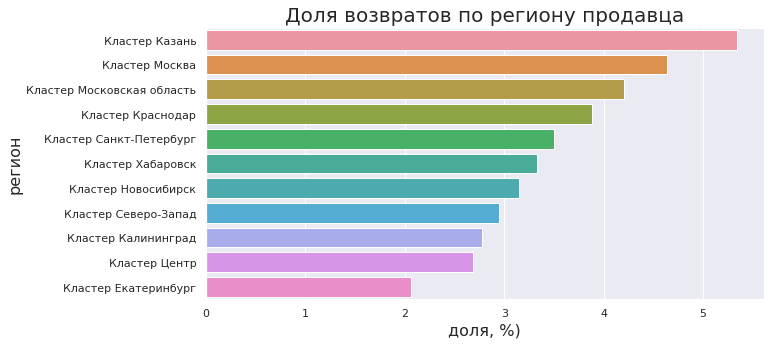

In [100]:
sns.set(rc={'figure.figsize':(10,5)})
p = sns.barplot(data = overall.groupby('warehouse_cluster', as_index=False).return_rate.mean() \
        .sort_values('return_rate', ascending=False), y='warehouse_cluster', x='return_rate')
p.set_title("Доля возвратов по региону продавца",fontsize=20)
p.set_xlabel("доля, %)",fontsize=16)
p.set_ylabel("регион",fontsize=16)
plt.show()

**Return rate по региону покупателя**

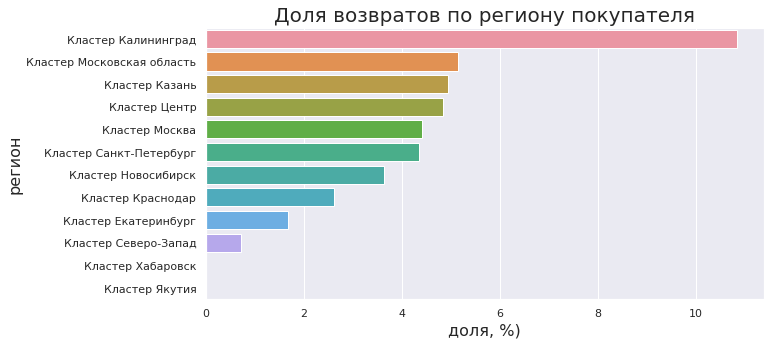

In [101]:
p = sns.barplot(data = overall.groupby('customer_cluster', as_index=False).return_rate.mean() \
        .sort_values('return_rate', ascending=False), y='customer_cluster', x='return_rate')
p.set_title("Доля возвратов по региону покупателя",fontsize=20)
p.set_xlabel("доля, %)",fontsize=16)
p.set_ylabel("регион",fontsize=16)
plt.show()

### GMV D-R - совокупный объем доставленных заказов за вычетом возвратов, в рублях

 - Визуализировать изменение метрики по дням;
 - Визуализировать разрезы по:
     - перевозчикам
     - типу доставки
     - региону нахождения продавца

In [102]:
gmvdr = gross.merge(returns[['number_order','product_ID', 'amount_return']], on =['number_order','product_ID'], how='left')

In [103]:
gmvdr.head(3)

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster,date_err,product_ID,product_price,amount,gmv_accept,amount_return
0,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,983587801,5512.44,1,5512.44,NaN
1,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,983587158,4070.35,2,8140.70,NaN
2,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,983582669,3591.97,1,3591.97,NaN


In [104]:
# Заменим недостающие данные нулями
gmvdr['amount_return'] = gmvdr['amount_return'].fillna(0)
gmvdr.shape

(11677, 17)

In [105]:
# Удалим данные по недоставленным заказам
gmvdr = gmvdr[gmvdr['result_data_order'].notna()]
gmvdr.shape

(9983, 17)

In [106]:
# Посчитаем выручку за вычетом возвратов
gmvdr['value'] = (gmvdr['amount'] - gmvdr['amount_return']) * gmvdr['product_price']
gmvdr.head()

,date_order,number_order,planned_data_order,timeslot_number,result_data_order,delivery_type,carrier_name,seller_ID,order_status,customer_cluster,warehouse_cluster,date_err,product_ID,product_price,amount,gmv_accept,amount_return,value
0,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,983587801,5512.44,1,5512.44,0.0,5512.44
1,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,983587158,4070.35,2,8140.70,0.0,8140.70
2,2021-01-05,313655114,2021-01-14,1,2021-01-11,Самовывоз,3PL 1,301202,Доставлен,Кластер Краснодар,Кластер Москва,False,983582669,3591.97,1,3591.97,0.0,3591.97
3,2021-01-03,315229153,2021-01-11,1,2021-01-08,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область,False,983589424,4433.23,3,13299.69,0.0,13299.69
4,2021-01-03,315229153,2021-01-11,1,2021-01-08,Курьер,Самодоставка,40560,Доставлен,Кластер Московская область,Кластер Московская область,False,983587827,2862.50,2,5725.00,0.0,5725.00


In [107]:
# Дневная выручка за вычетом возвратов
gmvdr_daily = gmvdr.groupby('result_data_order', as_index=False).value.sum().sort_values('result_data_order')
gmvdr_daily.head()

,result_data_order,value
0,2020-12-25,24288.67
1,2020-12-29,75904.98
2,2020-12-30,67771.91
3,2020-12-31,19278.62
4,2021-01-02,19174.83


In [108]:
# Дневная выручка нарастающим итогом
gmvdr_daily['value'] = gmvdr_daily.value.cumsum()
gmvdr_daily.head()

,result_data_order,value
0,2020-12-25,24288.67
1,2020-12-29,100193.65
2,2020-12-30,167965.56
3,2020-12-31,187244.18
4,2021-01-02,206419.01


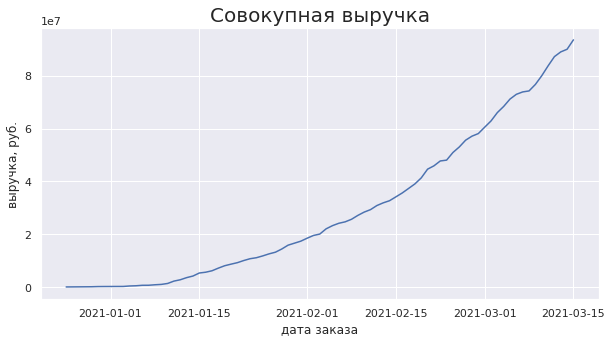

In [109]:
p = sns.lineplot(data=gmvdr_daily, x='result_data_order', y='value')
p.set_title("Совокупная выручка",fontsize=20)
p.set_xlabel("дата заказа",fontsize=12)
p.set_ylabel("выручка, руб.",fontsize=12)
plt.show()

**GMV D-R по перевозчикам**

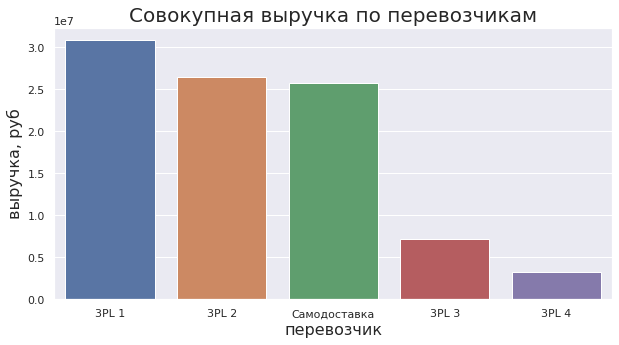

In [110]:
p = sns.barplot(data = gmvdr.groupby('carrier_name', as_index=False).value.sum() \
        .sort_values('value', ascending=False), x='carrier_name', y='value')
p.set_title("Совокупная выручка по перевозчикам",fontsize=20)
p.set_xlabel("перевозчик",fontsize=16)
p.set_ylabel("выручка, руб",fontsize=16)
plt.show()

**GMV D-R по типу доставки**

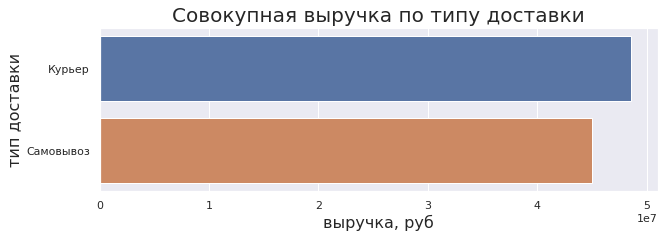

In [111]:
sns.set(rc={'figure.figsize':(10,3)})
p = sns.barplot(data = gmvdr.groupby('delivery_type', as_index=False).value.sum() \
        .sort_values('value', ascending=False), y='delivery_type', x='value')
p.set_title("Совокупная выручка по типу доставки",fontsize=20)
p.set_xlabel("выручка, руб",fontsize=16)
p.set_ylabel("тип доставки",fontsize=16)
plt.show()

**GMV D-R по региону продавца**

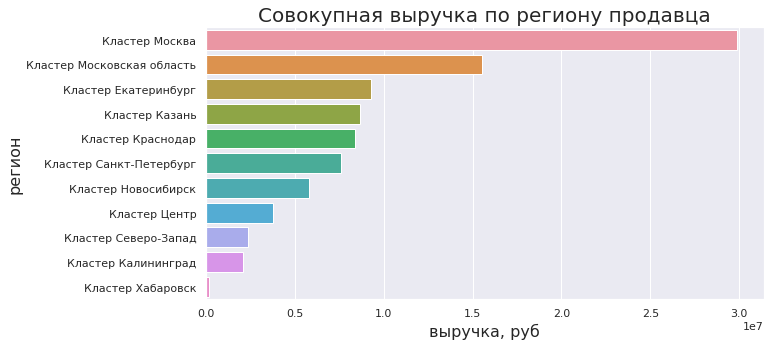

In [114]:
sns.set(rc={'figure.figsize':(10,5)})
p = sns.barplot(data = gmvdr.groupby('warehouse_cluster', as_index=False).value.sum() \
        .sort_values('value', ascending=False), y='warehouse_cluster', x='value')
p.set_title("Совокупная выручка по региону продавца",fontsize=20)
p.set_xlabel("выручка, руб",fontsize=16)
p.set_ylabel("регион",fontsize=16)
plt.show()